## Dataset

In [1]:
from datetime import datetime
reference_datetime=datetime(1970, 1, 1)

In [2]:
def encode_datetime_to_float(dt, reference_datetime=datetime(1970, 1, 1)):
    delta = dt - reference_datetime
    return delta.total_seconds()

In [3]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# gloabl params for all matplotlib plots
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [4]:
train_events=pd.read_csv('/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv')

In [5]:
serieses=train_events['series_id'].value_counts()
series=serieses.index

In [6]:
df=pd.read_parquet('/kaggle/input/zzzs-lightweight-training-dataset-target/Zzzs_train.parquet')

In [7]:
df.head()

,series_id,step,timestamp,anglez,enmo,awake
0,08db4255286f,0,2018-11-05T10:00:00-0400,-30.845301,0.0447,1
1,08db4255286f,1,2018-11-05T10:00:05-0400,-34.181801,0.0443,1
2,08db4255286f,2,2018-11-05T10:00:10-0400,-33.877102,0.0483,1
3,08db4255286f,3,2018-11-05T10:00:15-0400,-34.282101,0.0680,1
4,08db4255286f,4,2018-11-05T10:00:20-0400,-34.385799,0.0768,1


In [8]:
df['awake'].value_counts()

awake
1    8660676
0    4504884
Name: count, dtype: int64

In [9]:
temp_df=df[df['series_id']=='a9a2f7fac455']
temp_df.shape

(634680, 6)

In [10]:
# univariate data: Temp vs Time

uni_data_df = temp_df['awake']
uni_data_df.index = temp_df['timestamp']
uni_data_df.head()

timestamp
2017-10-27T16:45:00-0400    1
2017-10-27T16:45:05-0400    1
2017-10-27T16:45:10-0400    1
2017-10-27T16:45:15-0400    1
2017-10-27T16:45:20-0400    1
Name: awake, dtype: int64

<Axes: xlabel='timestamp'>

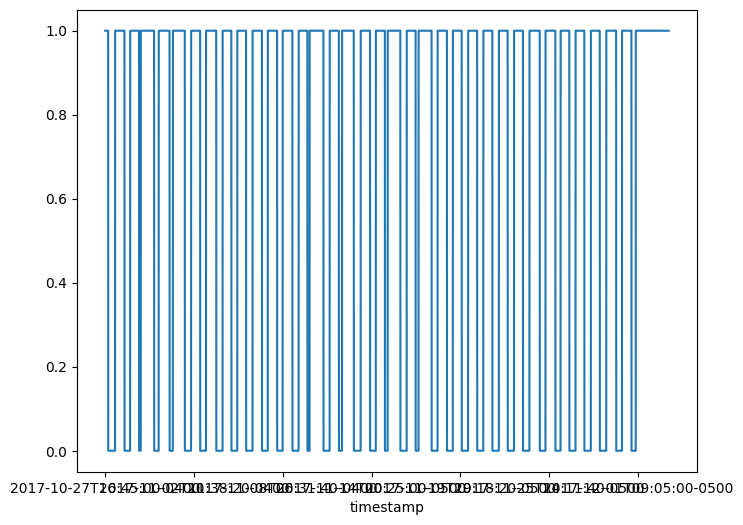

In [11]:
uni_data_df.plot()

In [12]:
uni_data = uni_data_df.values 

In [13]:
TRAIN_SPLIT = 400000

In [14]:
# This function creates the data we need for the above problem
# dataset: numpy ndarray
# start_index:
# end_index:
# history_size: k => take k values at a time
# target_size: 0 => next value in the time-series
# Output: data: (n,k) and labels (n,1)

def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)


# use the above function to create the datasets.
univariate_past_history = 200
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

print(x_train_uni.shape)
print(y_train_uni.shape)
print(x_val_uni.shape)
print(y_val_uni.shape)

(399800, 200, 1)
(399800,)
(234480, 200, 1)
(234480,)


In [15]:
#utility function
def create_time_steps(length):
  return list(range(-length, 0))

print(create_time_steps(20))

[-20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1]


<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.10/site-packages/matplotlib/pyplot.py'>

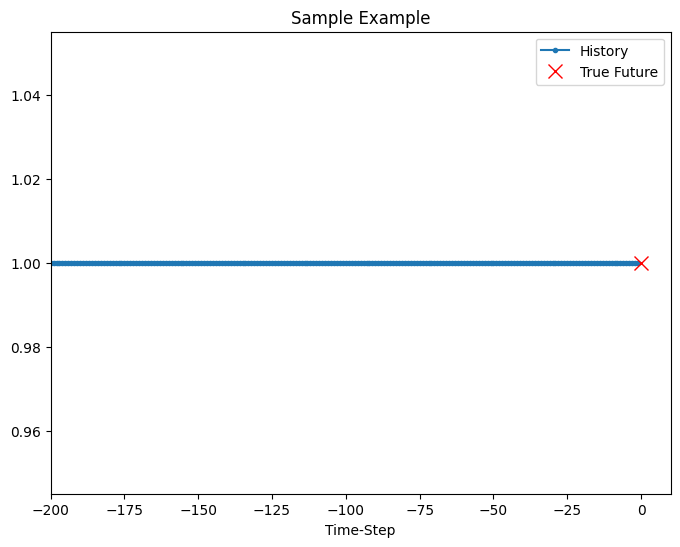

In [16]:
# Plotting function

# plot_data: contains labels as list
# delta: 0 => next time step given last "k" steps.
# title: plot title

# Usage: show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go'] # dot-line, red-x, green-o  refer: https://matplotlib.org/3.1.1/api/markers_api.html
  time_steps = create_time_steps(plot_data[0].shape[0])
  
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt


show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.10/site-packages/matplotlib/pyplot.py'>

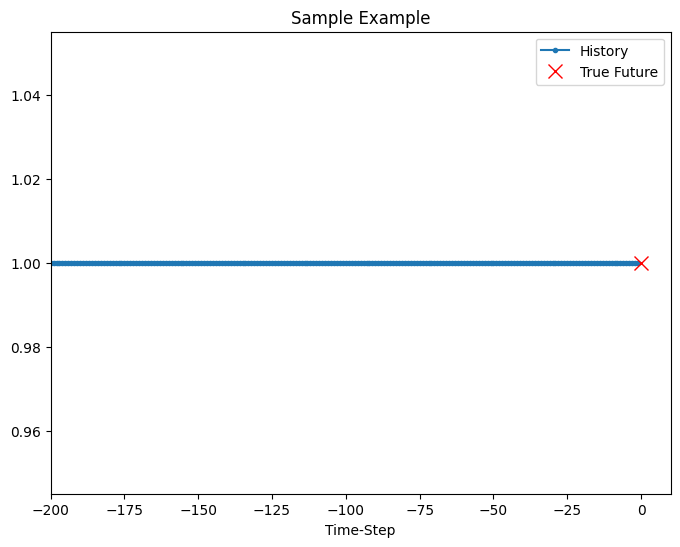

In [17]:
i=20
show_plot([x_train_uni[i], y_train_uni[i]], 0, 'Sample Example')

In [18]:
BATCH_SIZE = 256 # bacth size in batch-SGD/variants
BUFFER_SIZE = 10000 # for shuffling the dataset

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
#https://www.tensorflow.org/api_docs/python/tf/data/Dataset#repeat

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

print(train_univariate)
print(val_univariate)

<_RepeatDataset element_spec=(TensorSpec(shape=(None, 200, 1), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_RepeatDataset element_spec=(TensorSpec(shape=(None, 200, 1), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [19]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:],activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

simple_lstm_model.compile(optimizer='adam', loss='binary_crossentropy')

In [20]:
# Train and evaluate
STEPS_PER_EPOCH = 200
EPOCHS = 10

# https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=STEPS_PER_EPOCH,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 14s 62ms/step - loss: 168677687296.0000 - val_loss: 0.5855
Epoch 2/10
200/200 [==============================] - 12s 59ms/step - loss: 0.5809 - val_loss: 0.5844
Epoch 3/10
200/200 [==============================] - 12s 61ms/step - loss: 0.5663 - val_loss: 0.5805
Epoch 4/10
200/200 [==============================] - 12s 63ms/step - loss: 0.5550 - val_loss: 0.5785
Epoch 5/10
200/200 [==============================] - 12s 60ms/step - loss: 0.5302 - val_loss: 0.5854
Epoch 6/10
200/200 [==============================] - 12s 60ms/step - loss: 0.5240 - val_loss: 0.5864
Epoch 7/10
200/200 [==============================] - 12s 60ms/step - loss: 0.4932 - val_loss: 0.5966
Epoch 8/10
200/200 [==============================] - 12s 60ms/step - loss: 0.5199 - val_loss: 0.5889
Epoch 9/10
200/200 [==============================] - 12s 60ms/step - loss: 0.4817 - val_loss: 0.5954
Epoch 10/10
200/200 [==============================] - 12s 59ms/step - 

8/8 [==============================] - 0s 7ms/step


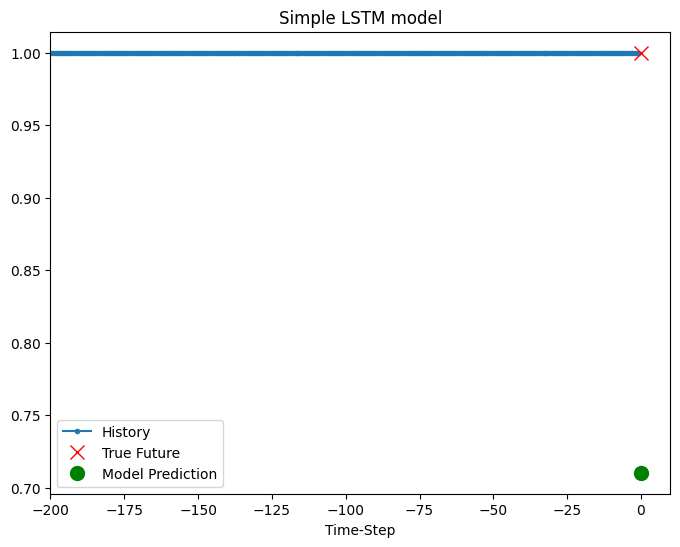

8/8 [==============================] - 0s 7ms/step


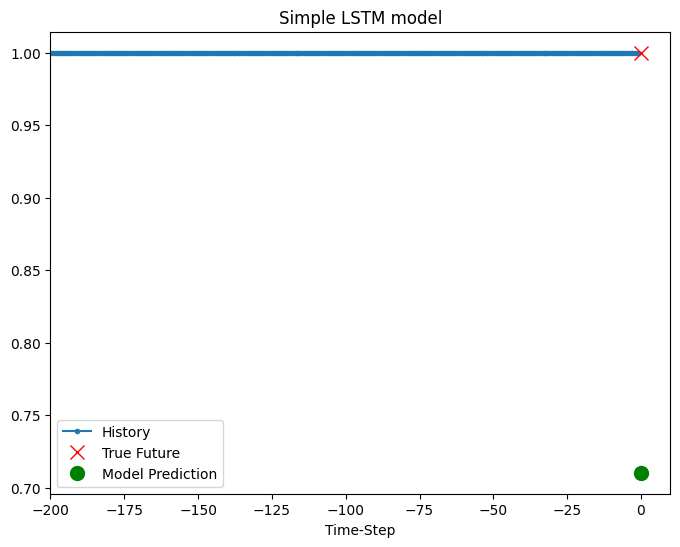

8/8 [==============================] - 0s 7ms/step


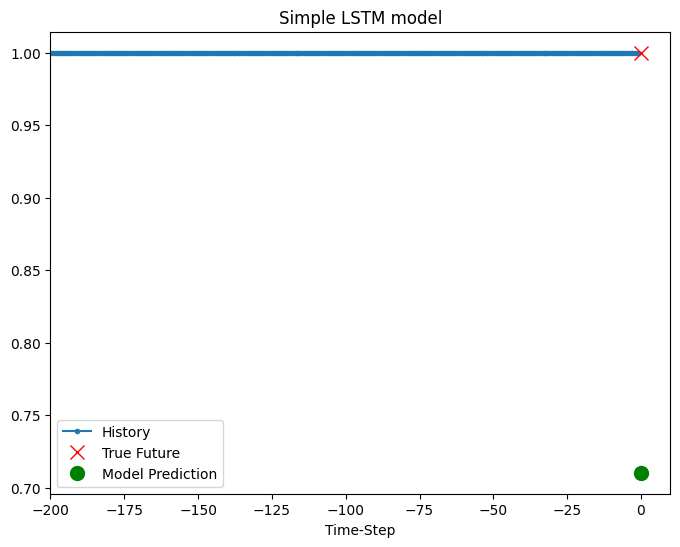

8/8 [==============================] - 0s 7ms/step


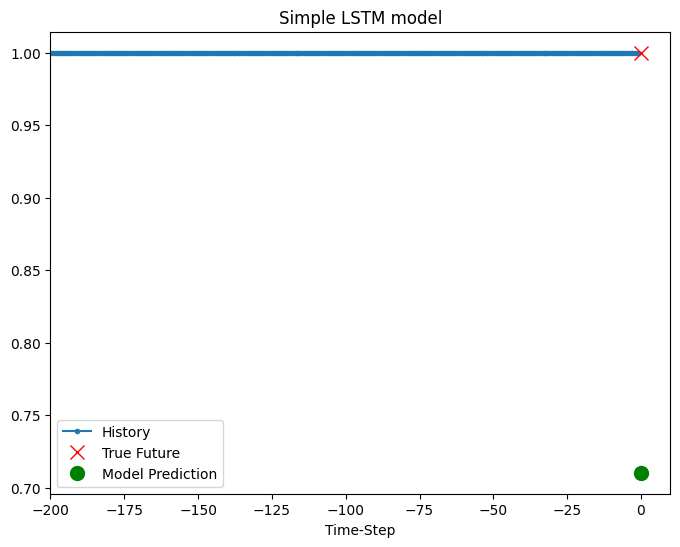

8/8 [==============================] - 0s 6ms/step


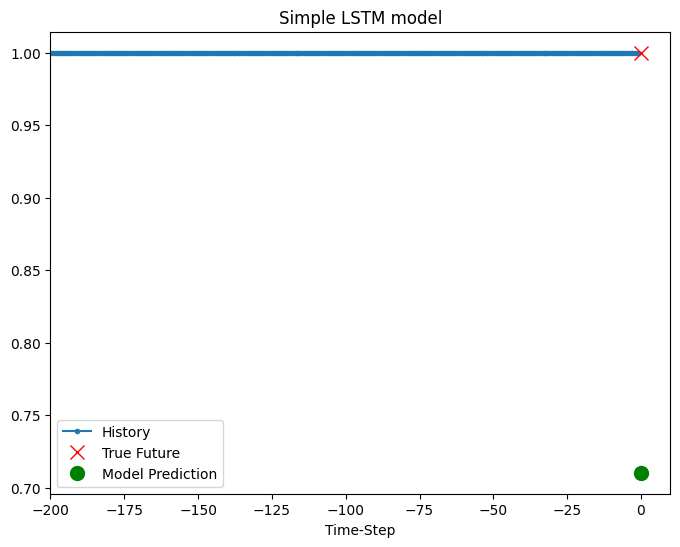

In [21]:
for x, y in val_univariate.take(5): # take 5 random inputs from validation data
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

## Multi-variate & single-step forecasting

- Problem definition: Given three features (p, T, rho) at each time stamp in the past, predict the temperature at a single time-stamp in the future.

In [22]:
# Features
features_considered = ['enmo', 'awake', 'anglez']

features = temp_df[features_considered]
features.index = temp_df['timestamp']
features.head()

,enmo,awake,anglez
timestamp,,,
2017-10-27T16:45:00-0400,0.0927,1,-62.350899
2017-10-27T16:45:05-0400,0.0408,1,-26.707100
2017-10-27T16:45:10-0400,0.0509,1,-33.740601
2017-10-27T16:45:15-0400,0.0833,1,24.313400
2017-10-27T16:45:20-0400,0.0305,1,27.792000


array([<Axes: xlabel='timestamp'>, <Axes: xlabel='timestamp'>,
       <Axes: xlabel='timestamp'>], dtype=object)

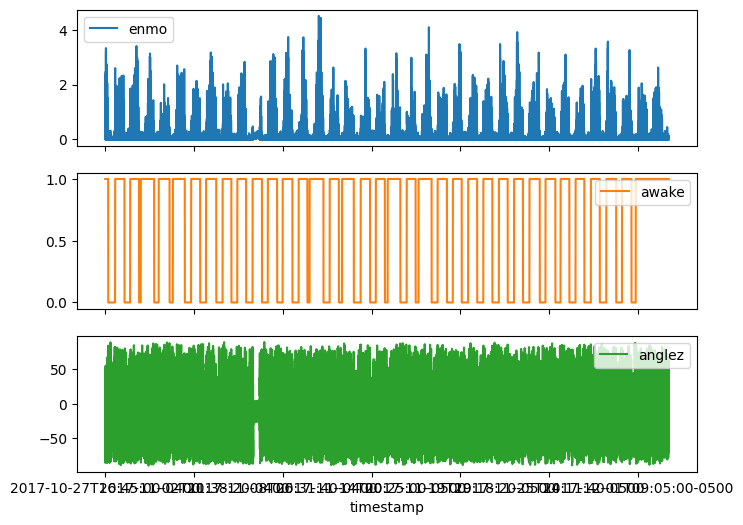

In [23]:
features.plot(subplots=True)

In [24]:
# Standardize data
TRAIN_SPLIT=400000
enmo_mean = features['enmo'][:TRAIN_SPLIT].mean()
enmo_std = features['enmo'][:TRAIN_SPLIT].std()
features['enmo'] = (features['enmo']-enmo_mean)/enmo_std

anglez_mean = features['anglez'][:TRAIN_SPLIT].mean()
anglez_std = features['anglez'][:TRAIN_SPLIT].std()
features['anglez'] = (features['anglez']-anglez_mean)/anglez_std

/tmp/ipykernel_47/2469065577.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['enmo'] = (features['enmo']-enmo_mean)/enmo_std
/tmp/ipykernel_47/2469065577.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['anglez'] = (features['anglez']-anglez_mean)/anglez_std


In [25]:
dataset=features.values

In [26]:
dataset.shape,features.shape

((634680, 3), (634680, 3))

In [27]:
# Same as univariate_data above.

# New params:
# step: instead of taking data for each 10min, do you want to generate data once evrey 6 steps (60min)
# single_step: lables from single timestamp or multiple timesteps


def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step) # step used here.
    data.append(dataset[indices])

    if single_step: # single_step used here.
      labels.append(target[i+target_size]) 
    else:
      labels.append(target[i:i+target_size]) 

  return np.array(data), np.array(labels)

In [28]:
# Generate data
past_history = 100 # 720*10 mins 
future_target = 1 # 72*10 mins
STEP = 1 # one obs every 6X10min = 60 min => 1 hr

# past history: 7200 mins => 120 hrs, sampling at one sample evry hours 
# future_target: 720 mins = > 12 hrs in the future, not next hour

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

print(x_train_single.shape)
print(y_train_single.shape)

(399900, 100, 3)
(399900,)


In [29]:
#TF dataset
BUFFER_SIZE=1000
BATCH_SIZE=256
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

print(train_data_single)
print(val_data_single)

<_RepeatDataset element_spec=(TensorSpec(shape=(None, 100, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>
<_RepeatDataset element_spec=(TensorSpec(shape=(None, 100, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>


In [30]:
# Model
STEPS_PER_EPOCH = 200
EPOCHS = 10
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:],activation='relu',return_sequences=True))
single_step_model.add(tf.keras.layers.LSTM(64,
                                           activation='relu',return_sequences=True))
single_step_model.add(tf.keras.layers.LSTM(32,
                                           activation='relu'))
single_step_model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

single_step_model.compile(optimizer='adam', loss='binary_crossentropy')

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=STEPS_PER_EPOCH,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
200/200 [==============================] - 57s 268ms/step - loss: 86.3990 - val_loss: 3.1329
Epoch 2/10
200/200 [==============================] - 55s 275ms/step - loss: 4.3821 - val_loss: 0.6805
Epoch 3/10
200/200 [==============================] - 57s 284ms/step - loss: 4280837.0000 - val_loss: 88156.8203
Epoch 4/10
200/200 [==============================] - 55s 276ms/step - loss: 17203.4668 - val_loss: 76561.7188
Epoch 5/10
200/200 [==============================] - 53s 267ms/step - loss: 7830.0498 - val_loss: 75.7333
Epoch 6/10
200/200 [==============================] - 52s 262ms/step - loss: 154.5428 - val_loss: 173.5660
Epoch 7/10
200/200 [==============================] - 52s 262ms/step - loss: 1269.1041 - val_loss: 2702.1213
Epoch 8/10
200/200 [==============================] - 52s 261ms/step - loss: 1664.6483 - val_loss: 32.2679
Epoch 9/10
200/200 [==============================] - 52s 259ms/step - loss: 29.4582 - val_loss: 33.6353
Epoch 10/10
200/200 [=============

In [31]:
# Plot train and validation loss over epochs

def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()
  plt.grid()

  plt.show()



8/8 [==============================] - 0s 23ms/step


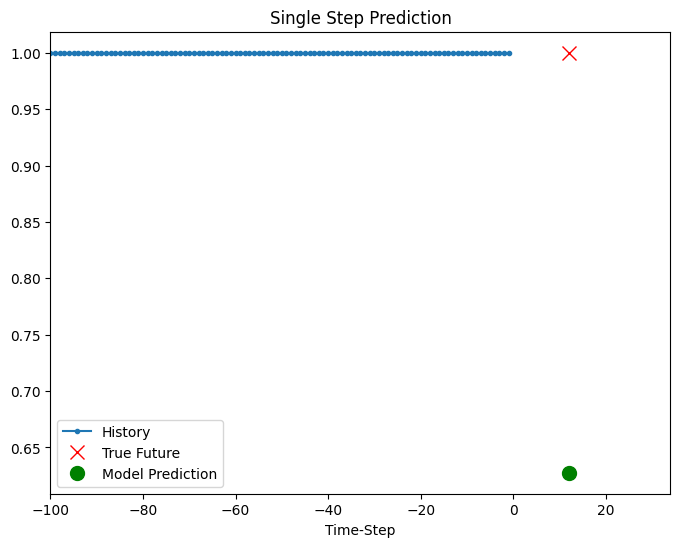

8/8 [==============================] - 0s 23ms/step


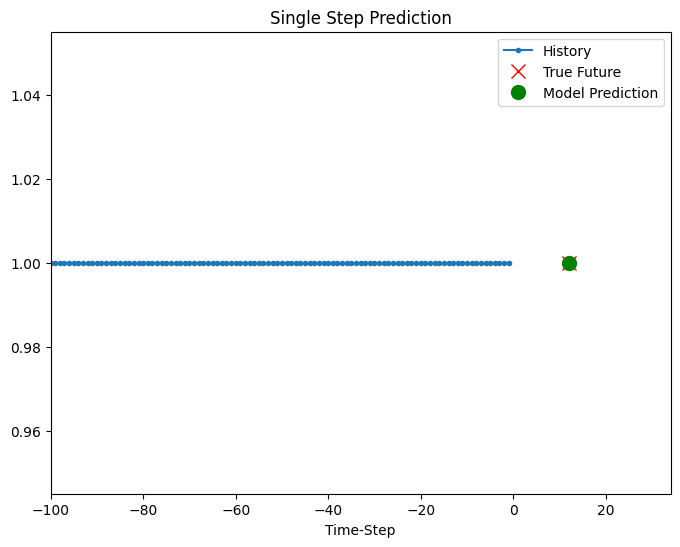

8/8 [==============================] - 0s 24ms/step


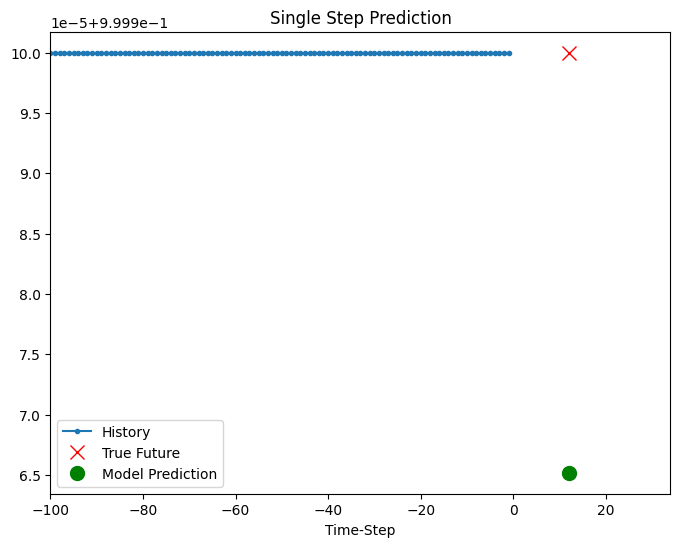

8/8 [==============================] - 0s 23ms/step


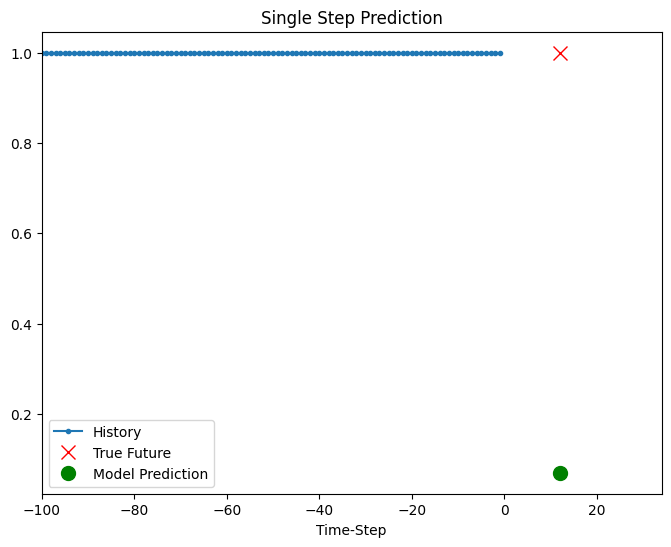

8/8 [==============================] - 0s 24ms/step


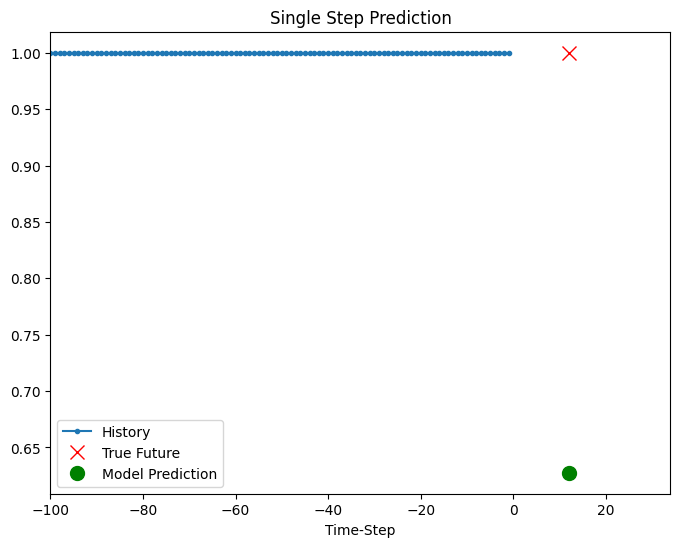

In [32]:
# plot time series and predicted values

for x, y in val_data_single.take(5):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()


## Multi-variate & multi-step forecasting
- Generate multiple future values of temperature

In [33]:
# single_step=FALSE default value

future_target = 10 # 72 future values
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

print(x_train_multi.shape)
print(y_train_multi.shape)
print(x_val_multi.shape)
print(y_val_multi.shape)

(399900, 100, 3)
(399900, 10)
(234570, 100, 3)
(234570, 10)


In [34]:
# TF DATASET

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

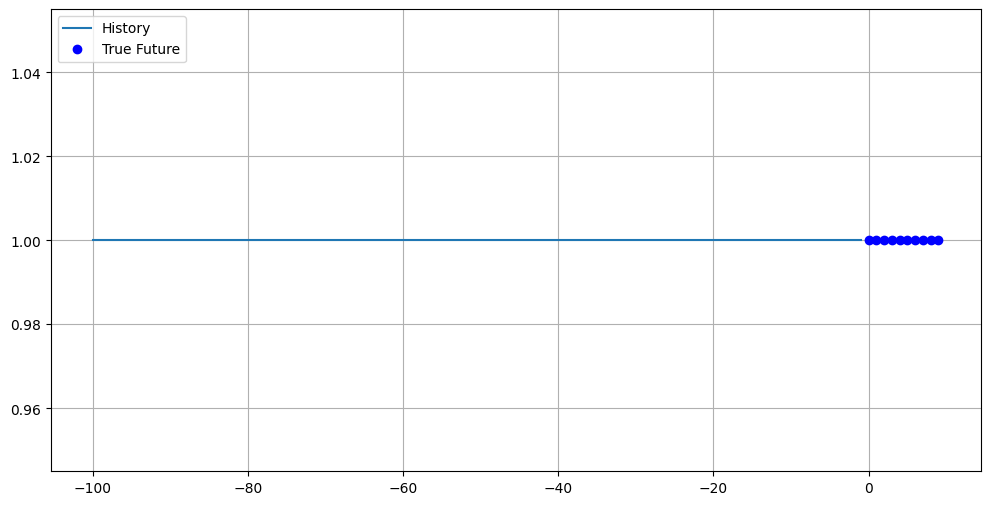

In [35]:
#plotting function
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)
  plt.grid()
  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()
  


for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [36]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(10,activation='sigmoid')) # for 72 outputs

multi_step_model.compile(optimizer='adam', loss='binary_crossentropy')

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=STEPS_PER_EPOCH,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
200/200 [==============================] - 22s 100ms/step - loss: 81.7109 - val_loss: 0.0472
Epoch 2/10
200/200 [==============================] - 20s 98ms/step - loss: 0.0401 - val_loss: 0.0333
Epoch 3/10
200/200 [==============================] - 20s 99ms/step - loss: 0.0290 - val_loss: 0.0304
Epoch 4/10
200/200 [==============================] - 20s 99ms/step - loss: 0.0260 - val_loss: 0.0241
Epoch 5/10
200/200 [==============================] - 19s 97ms/step - loss: 0.0245 - val_loss: 0.0149
Epoch 6/10
200/200 [==============================] - 19s 95ms/step - loss: 0.0226 - val_loss: 0.0213
Epoch 7/10
200/200 [==============================] - 19s 97ms/step - loss: 0.0223 - val_loss: 0.0217
Epoch 8/10
200/200 [==============================] - 19s 95ms/step - loss: 0.0169 - val_loss: 0.0047
Epoch 9/10
200/200 [==============================] - 19s 95ms/step - loss: 0.0196 - val_loss: 0.0173
Epoch 10/10
200/200 [==============================] - 19s 95ms/step - loss: 0.0

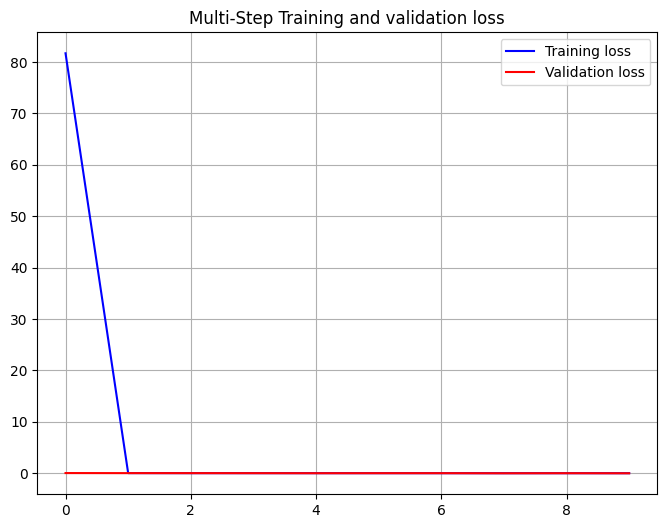

In [37]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')


8/8 [==============================] - 1s 12ms/step


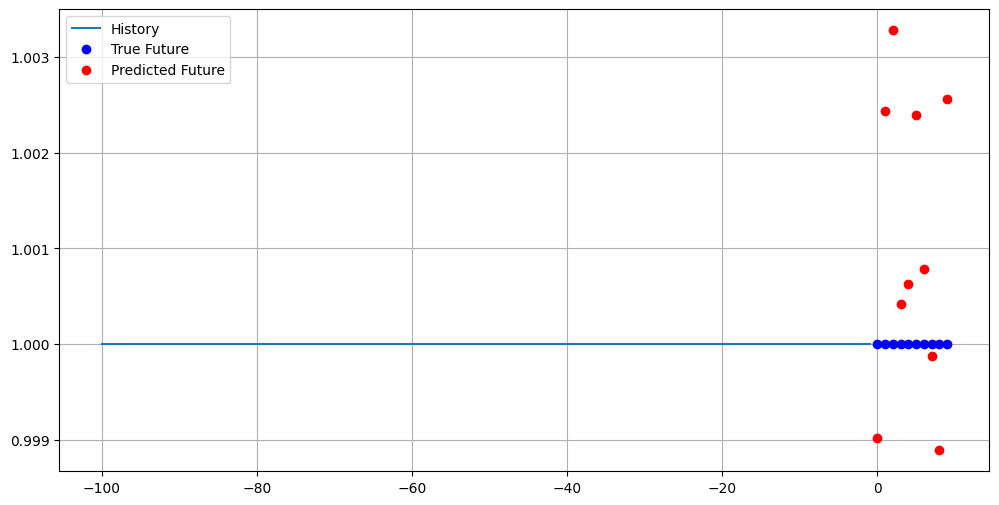

8/8 [==============================] - 0s 12ms/step


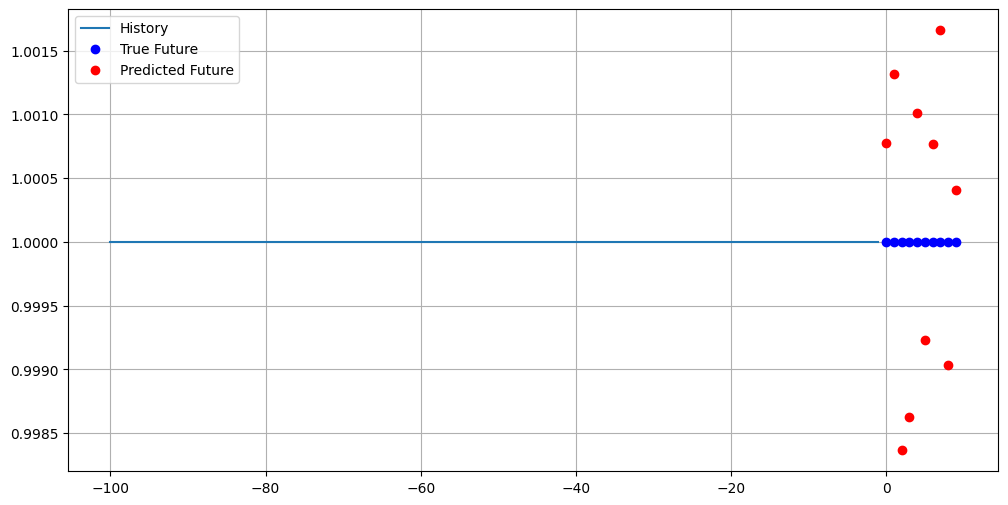

8/8 [==============================] - 0s 12ms/step


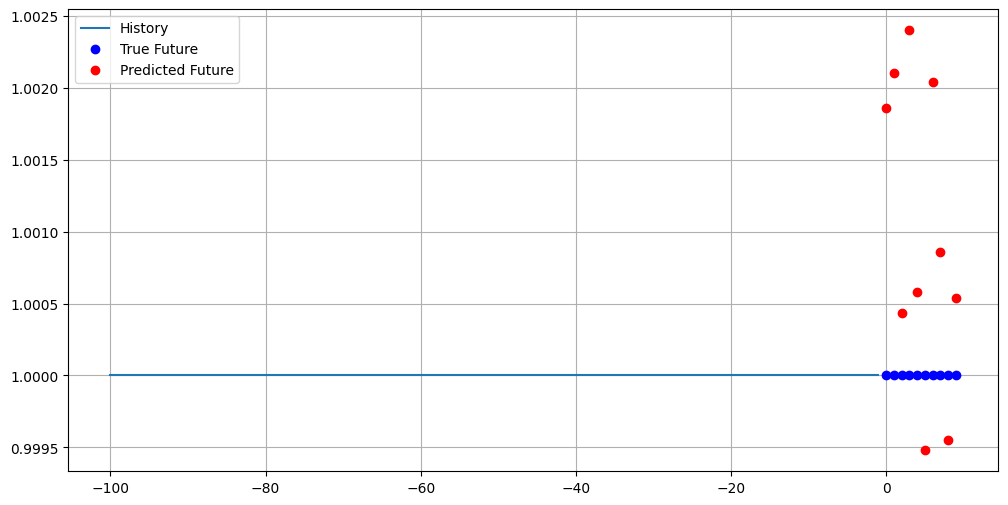

In [38]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

In [50]:
test_data=pd.read_parquet('/kaggle/input/child-mind-institute-detect-sleep-states/test_series.parquet')
test_data

,series_id,step,timestamp,anglez,enmo
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.636700,0.0217
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.636800,0.0215
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.637000,0.0216
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.636800,0.0213
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.636800,0.0215
...,...,...,...,...,...
445,0402a003dae9,145,2018-12-18T12:57:05-0500,-59.696899,0.0601
446,0402a003dae9,146,2018-12-18T12:57:10-0500,-35.656601,0.0427
447,0402a003dae9,147,2018-12-18T12:57:15-0500,-21.582399,0.0309
448,0402a003dae9,148,2018-12-18T12:57:20-0500,-42.616001,0.0328


In [54]:
def perform_prediction(series_id,test_data):
    test_data=test_data[test_data['series_id']==series_id]
    features_considered = ['enmo', 'anglez']
    test = test_data[features_considered]
    test.index = test_data['timestamp']
    predictions=[]
    dataset=test.values
    i=0
    random_history=list(np.random.randint(0,2,(100)))
    history_size=100
    while i+history_size<test.shape[0]:
        data=[]
        for j in range(i,i+history_size):
            temp=list(dataset[j])
            temp.append(random_history[j])
            data.append(temp)
        data=np.array([data])
        prediction=single_step_model.predict(data)[0][0]
        if prediction<0.5:
            prediction=0
        else:
            prediction=1
        predictions.append(prediction)
        random_history.append(prediction)
        i+=1
    return predictions

In [55]:
predictions=perform_prediction('038441c925bb',test_data)

1/1 [==============================] - 0s 26ms/step


[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [56]:
result_df=pd.DataFrame()
temp=[]
for id in test_data['series_id'].unique():
    temp.append(id)
    temp.append(id)
result_df['series_id']=temp

In [66]:
len(predictions)

50

In [67]:
temp_df=pd.DataFrame()
temp_df['series_id']=test_data['series_id'][:50]
temp_df['timestamp']=test_data['timestamp'][:50]
temp_df['awake']=predictions

In [68]:
temp_df

,series_id,timestamp,awake
0,038441c925bb,2018-08-14T15:30:00-0400,1
1,038441c925bb,2018-08-14T15:30:05-0400,1
2,038441c925bb,2018-08-14T15:30:10-0400,1
3,038441c925bb,2018-08-14T15:30:15-0400,1
4,038441c925bb,2018-08-14T15:30:20-0400,1
5,038441c925bb,2018-08-14T15:30:25-0400,1
6,038441c925bb,2018-08-14T15:30:30-0400,1
7,038441c925bb,2018-08-14T15:30:35-0400,1
8,038441c925bb,2018-08-14T15:30:40-0400,1
9,038441c925bb,2018-08-14T15:30:45-0400,1


In [57]:
result_df

,series_id
0,038441c925bb
1,038441c925bb
2,03d92c9f6f8a
3,03d92c9f6f8a
4,0402a003dae9
5,0402a003dae9


In [62]:
result_df['event']=result_df.shape[0]//2*['onset','wakeup']

In [69]:
result_df

,series_id,step,event
0,038441c925bb,0,onset
1,038441c925bb,1,wakeup
2,03d92c9f6f8a,2,onset
3,03d92c9f6f8a,3,wakeup
4,0402a003dae9,4,onset
5,0402a003dae9,5,wakeup


In [70]:
def find_onset(sequence,test_data):
    for i in range(len(sequence)):
        if sequence[i]==1:
            return test_data['step'][i]
        else:
            return len(sequence)-1

In [72]:
def find_wakeup(sequence,test_data):
    for i in range(len(sequence)):
        if sequence[i]==0 and i>0 and sequence[i-1]==1:
            return test_data['step'][i]
        else:
            return 0